# Import Necessary Libraries

In [29]:
import pandas as pd
import numpy as np
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import Perceptron
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, confusion_matrix,  silhouette_score, adjusted_rand_score, normalized_mutual_info_score

# Exploratory Data Analysis

In [4]:
data = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
for col in data.select_dtypes(include='object').columns:
    print(f"\nColumn: {col}")
    print(data[col].value_counts(dropna=False))  # dropna=False counts NaN too



Column: customerID
customerID
3186-AJIEK    1
7590-VHVEG    1
5575-GNVDE    1
4501-VCPFK    1
6075-SLNIL    1
             ..
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
Name: count, Length: 7043, dtype: int64

Column: gender
gender
Male      3555
Female    3488
Name: count, dtype: int64

Column: Partner
Partner
No     3641
Yes    3402
Name: count, dtype: int64

Column: Dependents
Dependents
No     4933
Yes    2110
Name: count, dtype: int64

Column: PhoneService
PhoneService
Yes    6361
No      682
Name: count, dtype: int64

Column: MultipleLines
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64

Column: InternetService
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64

Column: OnlineSecurity
OnlineSecurity
No                     3498
Yes                    2019
No internet service    1526
Name: count, dtype: int64

Column: OnlineBack

## Removing Null from TotalCharges

In [6]:

# Step 1: replace blank strings with NaN
data['TotalCharges'] = data['TotalCharges'].replace(' ', np.nan)

# Step 2: convert to numeric
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

# Step 3: fill NaN with median
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())


In [7]:
data.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
Churn                object
dtype: object

In [8]:
data.shape

(7043, 21)

In [9]:
data.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [10]:
data.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

# Train-Test Split

In [11]:
data['Churn'].value_counts() #Imbalance in Target class

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [12]:
df = data.copy()

# Label encode all object columns
le = LabelEncoder()
for col in df.select_dtypes(include='object').columns:
    df[col] = le.fit_transform(df[col])

# Features & target
X = df.drop('Churn', axis=1)   # all features
y = df['Churn']                # target

# Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Fit on train, transform both train & test
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Training set shape: (5634, 20)
Test set shape: (1409, 20)


# Machine Learning Model analysis

## Logistic Regression

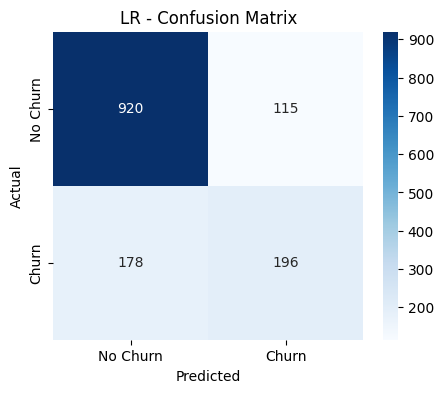

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1035
           1       0.63      0.52      0.57       374

    accuracy                           0.79      1409
   macro avg       0.73      0.71      0.72      1409
weighted avg       0.78      0.79      0.79      1409


ROC-AUC Score: 0.8371231496551189


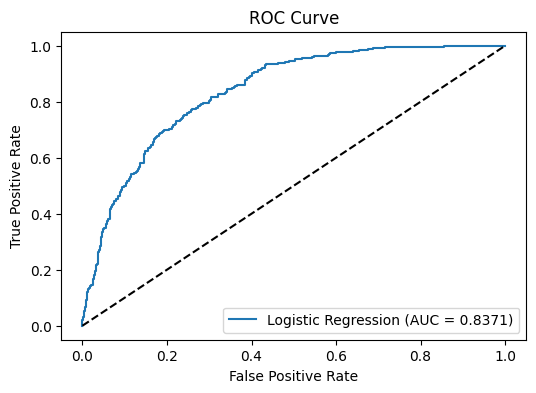

In [34]:
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# Predictions
y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:,1]   # probabilities for ROC-AUC

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Churn","Churn"], yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("LR - Confusion Matrix")
plt.show()

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Logistic Regression (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

## Random Forest

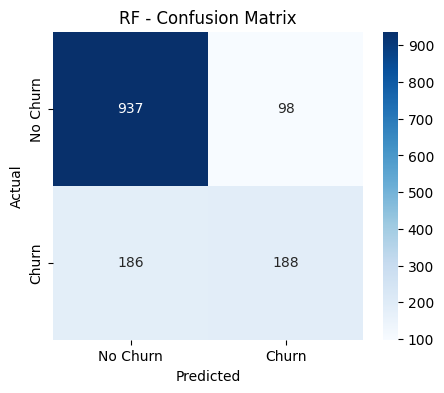

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409


ROC-AUC Score: 0.8305290759254954


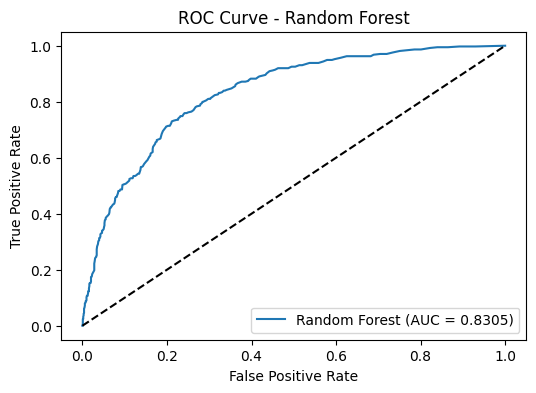

In [32]:
# ------------------ Model Training ------------------
rf = RandomForestClassifier(n_estimators=270, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]   # probabilities for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RF - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Random Forest (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.show()


## Support Vector Machines

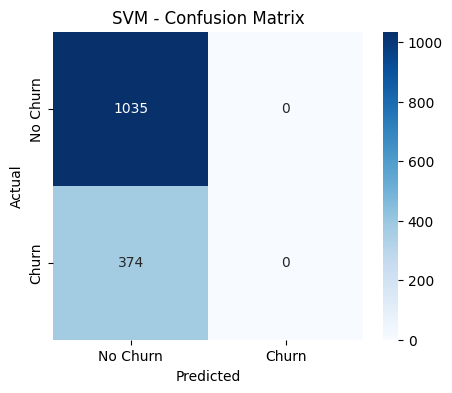

Classification Report:
               precision    recall  f1-score   support

           0       0.73      1.00      0.85      1035
           1       1.00      0.00      0.00       374

    accuracy                           0.73      1409
   macro avg       0.87      0.50      0.42      1409
weighted avg       0.81      0.73      0.62      1409


ROC-AUC Score: 0.5925702033118914


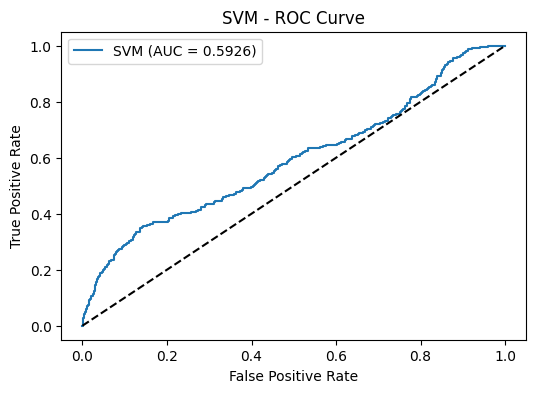

In [39]:
svm = SVC(kernel="rbf", probability=True, random_state=42)
svm.fit(X_train, y_train)

# Predictions
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:,1]   # probabilities for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("SVM - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 1))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="SVM (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM - ROC Curve")
plt.legend()
plt.show()


## Decision Tree

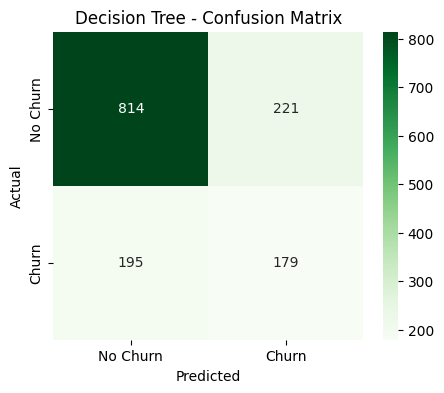

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.79      0.80      1035
           1       0.45      0.48      0.46       374

    accuracy                           0.70      1409
   macro avg       0.63      0.63      0.63      1409
weighted avg       0.71      0.70      0.71      1409


ROC-AUC Score: 0.6325415278100699


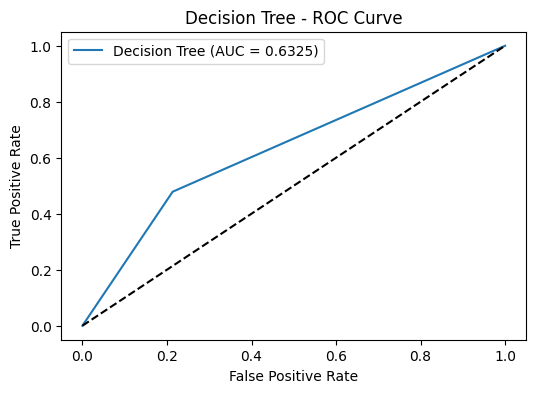

In [42]:
# ------------------ Train Decision Tree ------------------
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

# Predictions
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:,1]   # probabilities for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Decision Tree - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division = 1))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Decision Tree (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Decision Tree - ROC Curve")
plt.legend()
plt.show()


## Naive Bayes Classifier

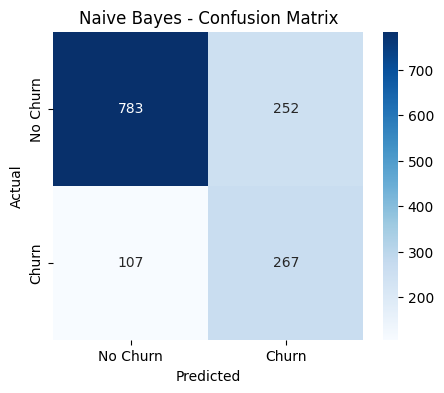

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.76      0.81      1035
           1       0.51      0.71      0.60       374

    accuracy                           0.75      1409
   macro avg       0.70      0.74      0.71      1409
weighted avg       0.78      0.75      0.76      1409


ROC-AUC Score: 0.8205016921129451


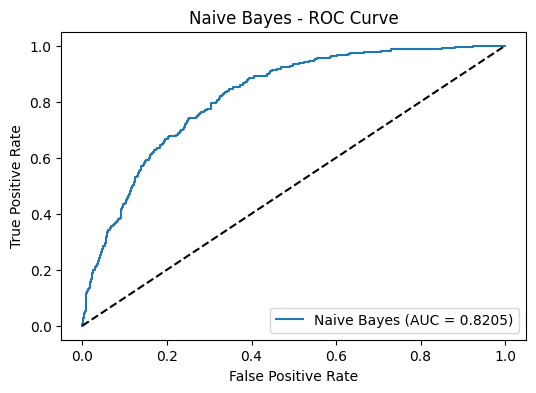

In [44]:
# ------------------ Model ------------------
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predictions
y_pred = nb.predict(X_test)
y_proba = nb.predict_proba(X_test)[:, 1]   # for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Naive Bayes - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Naive Bayes (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Naive Bayes - ROC Curve")
plt.legend()
plt.show()


## Gradient Boosting

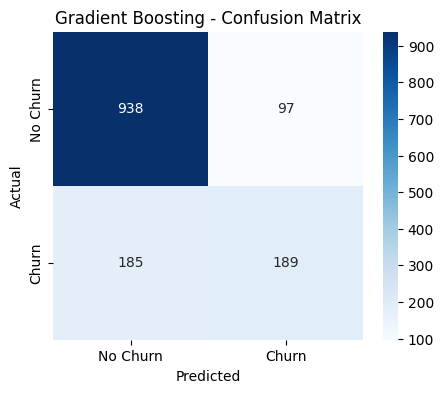

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.66      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


ROC-AUC Score: 0.8425030354697873


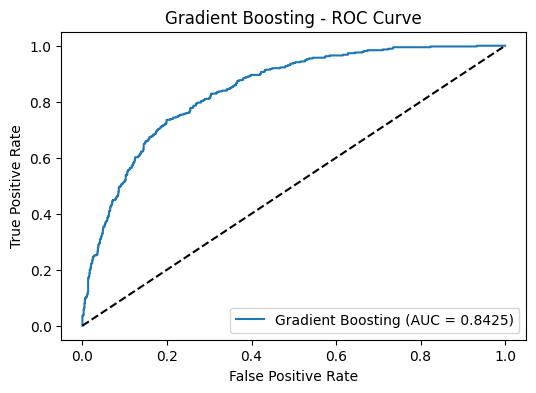

In [48]:
# ------------------ Model ------------------
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

# Predictions
y_pred = gb.predict(X_test)
y_proba = gb.predict_proba(X_test)[:, 1]   # for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Gradient Boosting - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Gradient Boosting (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Gradient Boosting - ROC Curve")
plt.legend()
plt.show()


## XGBoost

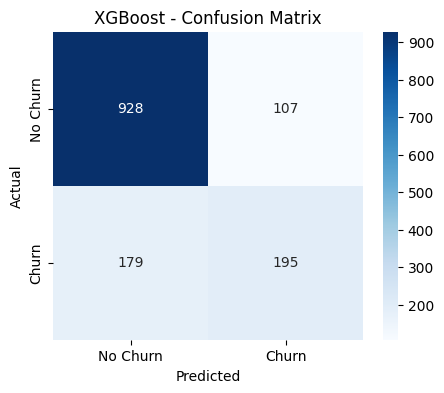

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


ROC-AUC Score: 0.8365238058332688


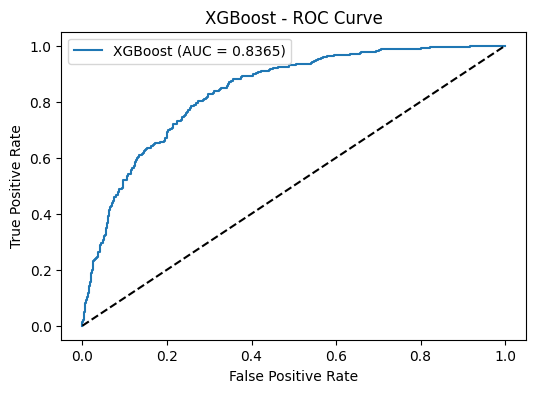

In [50]:
# ------------------ Model ------------------
xgb = XGBClassifier(
    n_estimators=200,      # number of trees
    learning_rate=0.1,     # shrinkage
    max_depth=4,           # depth of trees
    subsample=0.8,         # row sampling
    colsample_bytree=0.8,  # feature sampling
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss"  # suppresses warning
)

xgb.fit(X_train, y_train)

# Predictions
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]   # for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("XGBoost - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="XGBoost (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.legend()
plt.show()


## CatBoost

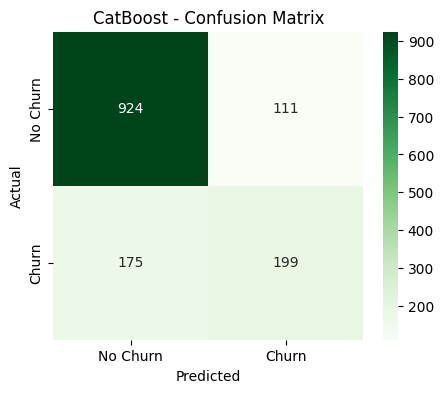

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409


ROC-AUC Score: 0.8354310367098091


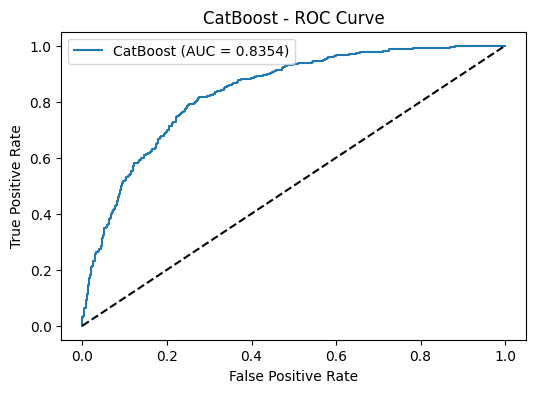

In [52]:
# CatBoost model
cb = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    eval_metric="AUC",
    random_seed=42,
    verbose=0
)

cb.fit(X_train, y_train)

# Predictions
y_pred = cb.predict(X_test)
y_proba = cb.predict_proba(X_test)[:, 1]   # for ROC-AUC

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("CatBoost - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

# ------------------ ROC Curve ------------------
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="CatBoost (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("CatBoost - ROC Curve")
plt.legend()
plt.show()


## K-means Clustering (Unsupervised Implementation)

Silhouette Score (unsupervised): 0.1501
Adjusted Rand Index (supervised comparison): 0.0000
Normalized Mutual Information (supervised comparison): 0.0000
IoU-like score: 0.0000


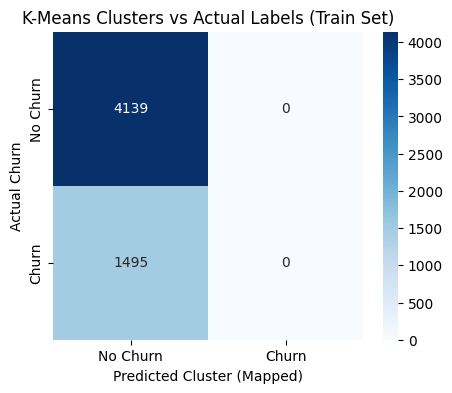

In [26]:
from collections import Counter

X_train_kmeans = X_train.copy()

# Encode categorical columns
for col in X_train_kmeans.select_dtypes(include='object').columns:
    X_train_kmeans[col] = LabelEncoder().fit_transform(X_train_kmeans[col])

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_kmeans)

# ------------------ K-Means Clustering ------------------
kmeans = KMeans(n_clusters=2, n_init=10, random_state=42)
y_kmeans_train = kmeans.fit_predict(X_train_scaled)

# ------------------ Map cluster labels to true labels ------------------
labels_mapping = {}
for cluster in np.unique(y_kmeans_train):
    mask = y_kmeans_train == cluster
    most_common = Counter(y_train[mask]).most_common(1)[0][0]
    labels_mapping[cluster] = most_common

y_kmapped_train = np.array([labels_mapping[cluster] for cluster in y_kmeans_train])

# ------------------ Metrics ------------------
# Silhouette Score (unsupervised)
sil_score = silhouette_score(X_train_scaled, y_kmeans_train)
print("Silhouette Score (unsupervised): {:.4f}".format(sil_score))

# Adjusted Rand Index
ari_score = adjusted_rand_score(y_train, y_kmapped_train)
print("Adjusted Rand Index (supervised comparison): {:.4f}".format(ari_score))

# Normalized Mutual Information
nmi_score = normalized_mutual_info_score(y_train, y_kmapped_train)
print("Normalized Mutual Information (supervised comparison): {:.4f}".format(nmi_score))

# IoU-like measure
cm = confusion_matrix(y_train, y_kmapped_train)
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]
iou = TP / (TP + FP + FN)
print("IoU-like score: {:.4f}".format(iou))

# ------------------ Confusion Matrix Plot ------------------
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted Cluster (Mapped)")
plt.ylabel("Actual Churn")
plt.title("K-Means Clusters vs Actual Labels (Train Set)")
plt.show()


# Deep Learning Model Analysis

## Artificial Neural Network

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


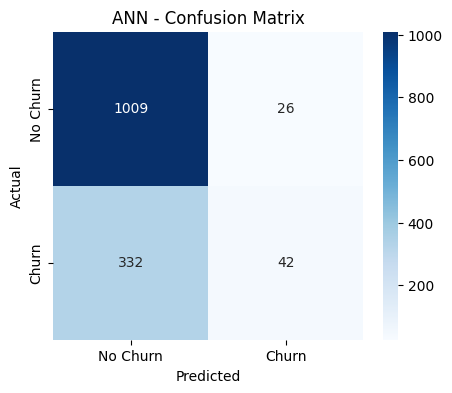

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.97      0.85      1035
           1       0.62      0.11      0.19       374

    accuracy                           0.75      1409
   macro avg       0.69      0.54      0.52      1409
weighted avg       0.72      0.75      0.67      1409


ROC-AUC Score: 0.7521


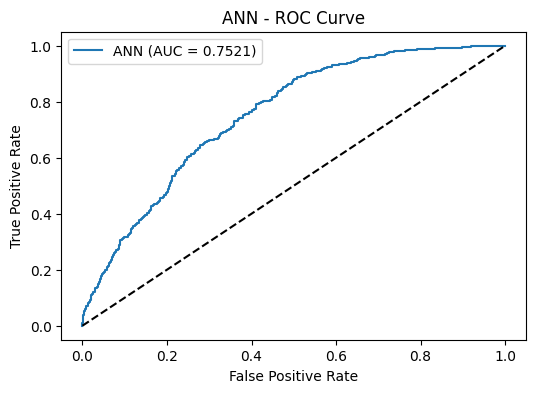

In [31]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow INFO/WARNING logs

# ------------------ Build ANN ------------------
ann = Sequential([
    Input(shape=(X_train.shape[1],)),  # <- Use Input layer instead of input_shape in Dense
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

ann.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# ------------------ Train ------------------
ann.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# ------------------ Predictions ------------------
y_proba = ann.predict(X_test).ravel()
y_pred = (y_proba > 0.5).astype(int)

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("ANN - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))

# ------------------ ROC Curve ------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ANN (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ANN - ROC Curve")
plt.legend()  
plt.show()


## Perceptron

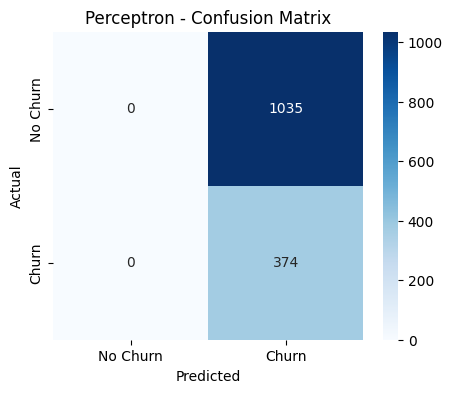

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.00      0.00      1035
           1       0.27      1.00      0.42       374

    accuracy                           0.27      1409
   macro avg       0.63      0.50      0.21      1409
weighted avg       0.81      0.27      0.11      1409


ROC-AUC Score: 0.5127


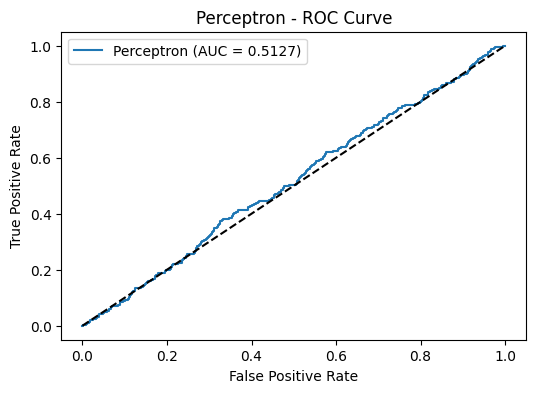

In [15]:

# Model
perc = Perceptron(max_iter=1000, random_state=42)
perc.fit(X_train, y_train)

# Predictions (Perceptron has decision_function)
y_pred = perc.predict(X_test)
y_proba = perc.decision_function(X_test)  

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Perceptron - Confusion Matrix")
plt.show()

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="Perceptron (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Perceptron - ROC Curve")
plt.legend()
plt.show()


## MultiLayer Perceptron

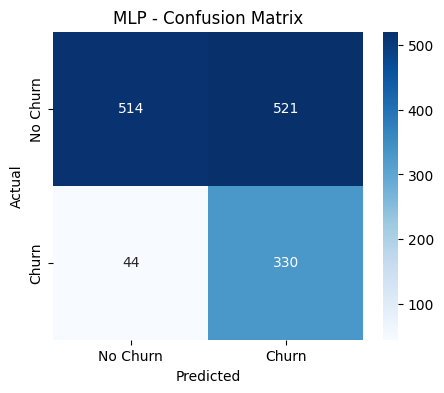

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.50      0.65      1035
           1       0.39      0.88      0.54       374

    accuracy                           0.60      1409
   macro avg       0.65      0.69      0.59      1409
weighted avg       0.78      0.60      0.62      1409


ROC-AUC Score: 0.7856


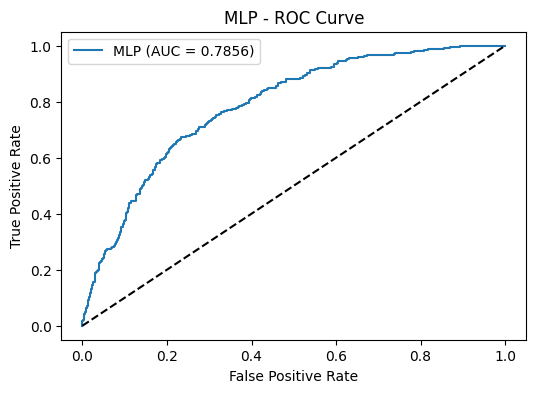

In [16]:
# Model
mlp = MLPClassifier(hidden_layer_sizes=(32,16), activation='relu', solver='adam', 
                    max_iter=500, random_state=42)
mlp.fit(X_train, y_train)

# Predictions
y_pred = mlp.predict(X_test)
y_proba = mlp.predict_proba(X_test)[:, 1]

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("MLP - Confusion Matrix")
plt.show()

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="MLP (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("MLP - ROC Curve")
plt.legend()
plt.show()


## Deep Neural Network

45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


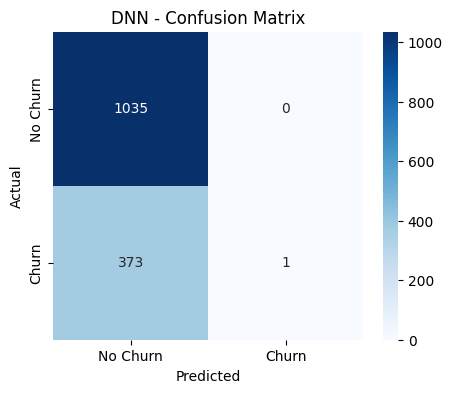

Classification Report:
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1035
           1       1.00      0.00      0.01       374

    accuracy                           0.74      1409
   macro avg       0.87      0.50      0.43      1409
weighted avg       0.81      0.74      0.62      1409


ROC-AUC Score: 0.4996


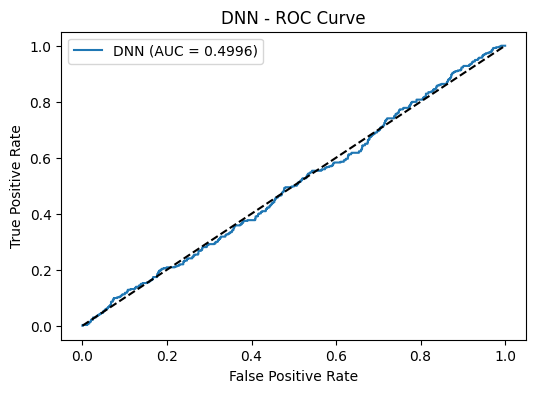

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------ Build Deep Neural Network (with Input layer) ------------------
dnn = Sequential([
    Input(shape=(X_train.shape[1],)),  # First layer is Input
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

dnn.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])

# ------------------ Train ------------------
history = dnn.fit(X_train, y_train, epochs=30, batch_size=32, verbose=0)

# ------------------ Predictions ------------------
y_proba = dnn.predict(X_test).ravel()
y_pred = (y_proba > 0.5).astype(int)

# ------------------ Confusion Matrix ------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["No Churn","Churn"], 
            yticklabels=["No Churn","Churn"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("DNN - Confusion Matrix")
plt.show()

# ------------------ Evaluation ------------------
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))
print("\nROC-AUC Score: {:.4f}".format(roc_auc_score(y_test, y_proba)))

# ------------------ ROC Curve ------------------
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="DNN (AUC = {:.4f})".format(roc_auc_score(y_test, y_proba)))
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("DNN - ROC Curve")
plt.legend()
plt.show()
